In [1]:
%matplotlib notebook

import matplotlib as mpl
import pandas as pd
import sys
mpl.style.use('ggplot')
import matplotlib.pyplot as plt
from os.path import isfile,exists
import math
import numpy as np
import os
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
import ujson
import tensorflow as tf
from keras import backend as K
from keras import regularizers
from keras.layers import Dense, GRU, Conv1D, MaxPool1D, GlobalMaxPool1D,MaxPooling1D
from keras.models import Model, Sequential
from trainer.model import LOOKBACK, model_fn, compile_model
from keras.preprocessing.sequence import pad_sequences

/Users/joelvogt/Development/PycharmProjects/machine-learning/venv/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Data exploration


In [2]:
df = pd.read_pickle('../data/evt_office_london.p')


In [3]:
df.groupby('appliance').size()

appliance
coffee_machine        2411
nespresso_machine     2033
noise_notappliance    1284
dtype: int64

In [4]:
def visualize_vibration(df, appliance, window):
#     pd.DataFrame(pd.DataFrame(df[df.appliance==appliance][['x','y','z']].values,columns=['x','y','z']).apply(np.square).sum(axis=1).apply(np.sqrt),columns=['magnitude']).rolling(window).mean().plot()
    pd.DataFrame(df[df.appliance==appliance][['x','y','z']].values,columns=['x','y','z']).rolling(window).mean().plot(subplots=True, title=appliance)

<IPython.core.display.Javascript object>


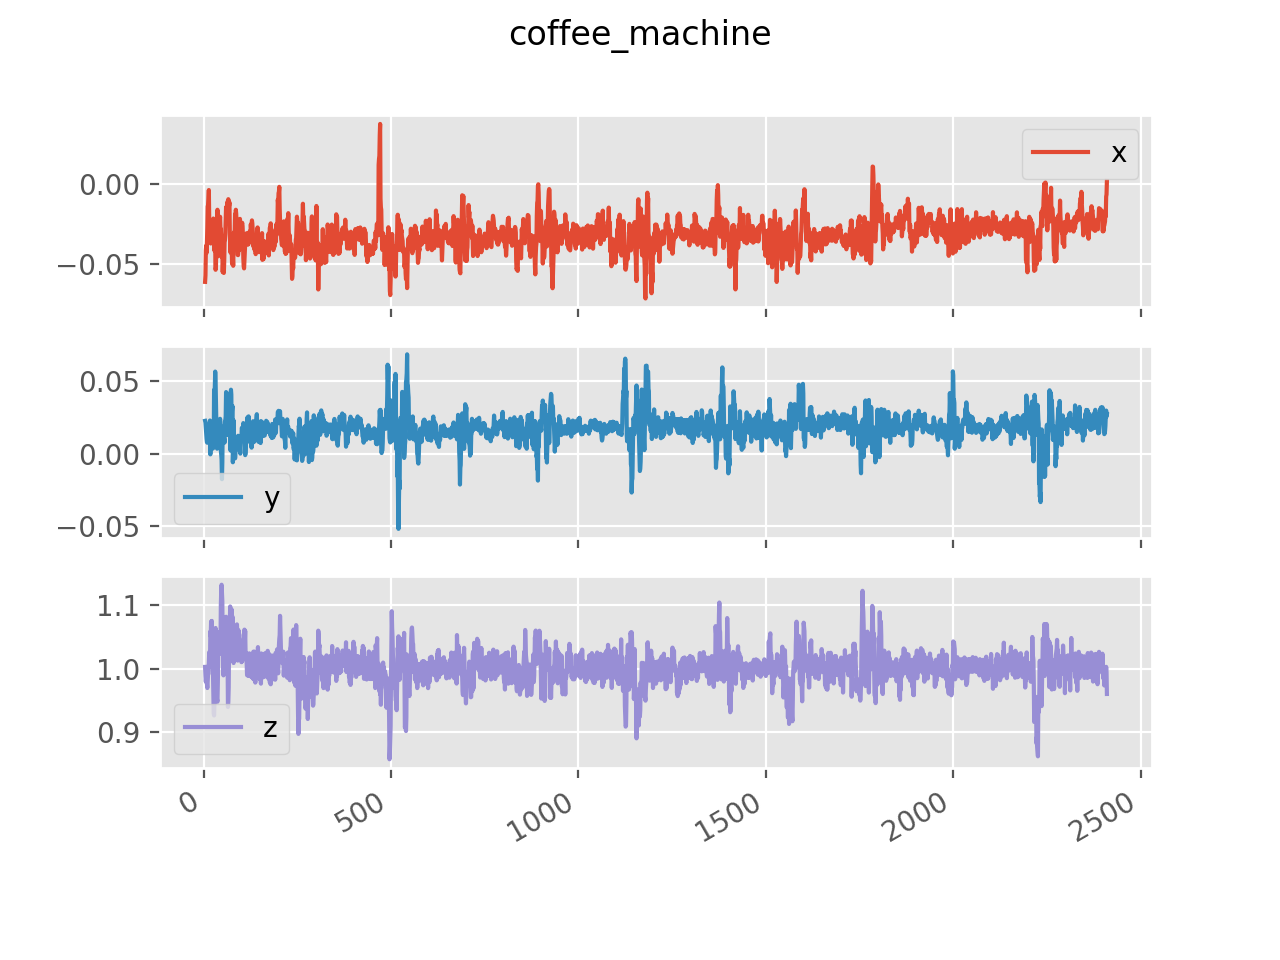

In [5]:
visualize_vibration(df, 'coffee_machine', 5)

In [6]:
# visualize_vibration(df, 'noise_notappliance', 5)

<IPython.core.display.Javascript object>


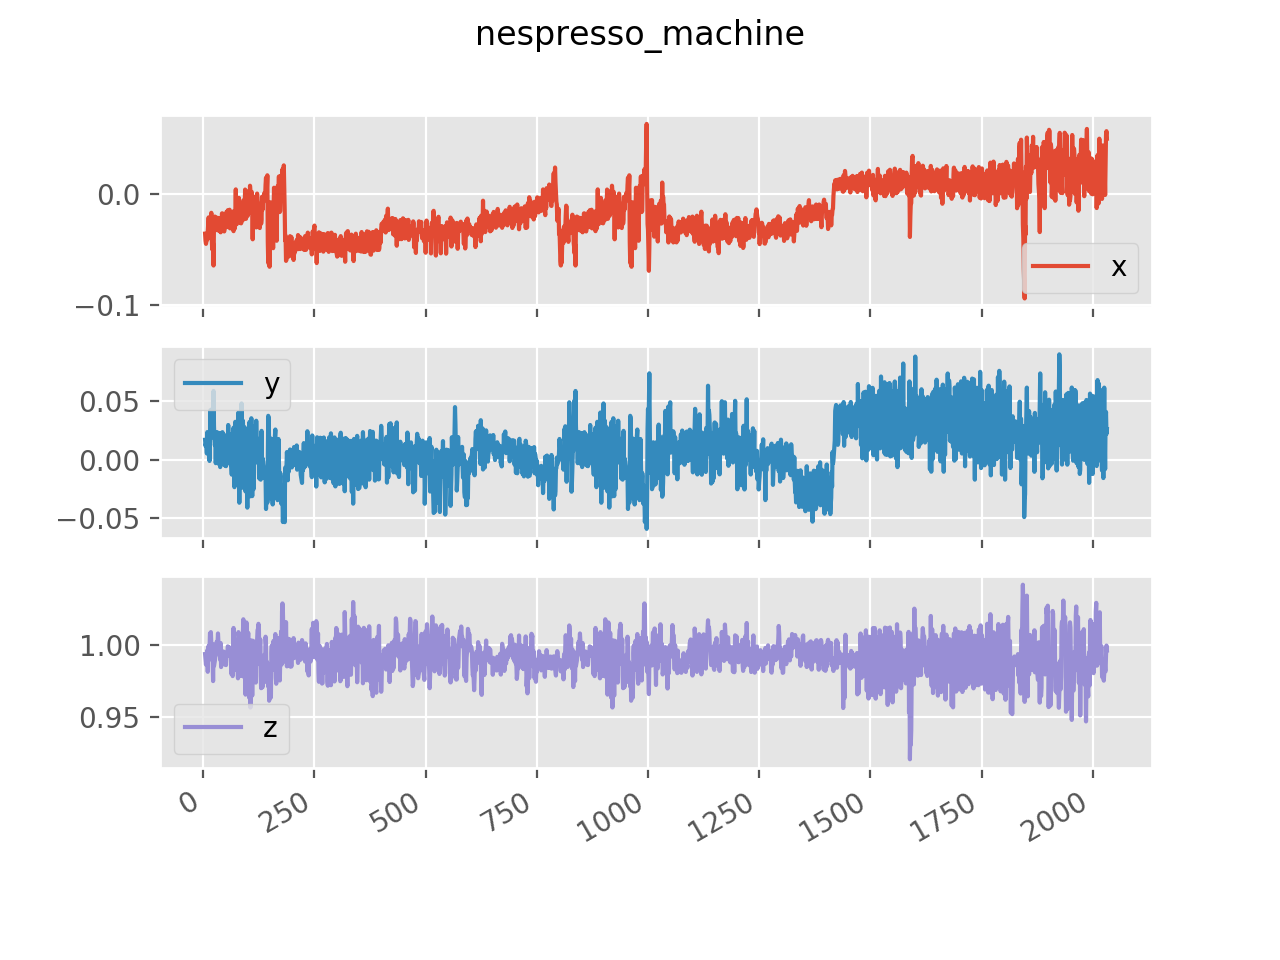

In [7]:
visualize_vibration(df, 'nespresso_machine', 5)

# Data preparation

## Splitting the data into a training and test set

In [8]:
def window(data,label,label_dtype, lookback):
    X = np.empty(shape=(len(data) - lookback + 1,lookback,len(data[0])), dtype=np.float32)
    y = np.empty(len(X), label_dtype)
    y[:] = label
    for i in range(len(data) - lookback+1):
        X[i,:] = data[i:i+lookback]
    return X, y

In [9]:
train_x, train_y, test_x, test_y, validate_x, validate_y = [],[],[],[],[],[]
split = 0.7

label_dtype = 'U{}'.format(max(map(lambda x: len(x),df.appliance.unique())) )
class_size = dict(zip(df.appliance.unique(), np.zeros(len(df.appliance.unique()))))
for label_ts, values in df.groupby(['appliance', pd.Grouper(freq='120s')]):
    label,_ = label_ts
    if len(values) < LOOKBACK:
        continue
    data, labels = window(values[['x','y','z']].values, label, label_dtype, LOOKBACK)
    _train_x, _test_x = data[:int(len(data)*split)], data[int(len(data)*split):]
    _train_y, _test_y = labels[:int(len(labels)*split)],labels[int(len(labels)*split):]
    _train_x, _validate_x = _train_x[:int(len(_train_x)*split)],_train_x[int(len(_train_x)*split):]
    _train_y, _validate_y = _train_y[:int(len(_train_y)*split)],_train_y[int(len(_train_y)*split):]
    train_x.append(_train_x)
    test_x.append(_test_x)
    train_y.append(_train_y)
    test_y.append(_test_y)
    validate_x.append(_validate_x)
    validate_y.append(_validate_y)
    

train_x, train_y = np.vstack(train_x), np.concatenate(train_y) 
validate_x, validate_y = np.vstack(validate_x), np.concatenate(validate_y)
test_x, test_y = np.vstack(test_x), np.concatenate(test_y)

## Feature scaling

### Scale input data

In [10]:
stdsc = StandardScaler()
train_x = stdsc.fit_transform(np.vstack(train_x)).reshape(train_x.shape)
validate_x = stdsc.transform(np.vstack(validate_x)).reshape(validate_x.shape)
test_x = stdsc.transform(np.vstack(test_x)).reshape(test_x.shape)

### One-hot encoding of norminal labels

In [11]:
le = LabelEncoder()
train_y = le.fit_transform(train_y).reshape(-1,1)
validate_y = le.transform(validate_y).reshape(-1,1)
test_y = le.transform(test_y).reshape(-1,1)

In [12]:
train_y = np.array(train_y == np.arange(len(le.classes_)),dtype=float)
validate_y = np.array(validate_y == np.arange(len(le.classes_)),dtype=float)
test_y = np.array(test_y == np.arange(len(le.classes_)),dtype=float)

# Train and evaluate the model

In [13]:
model = model_fn(train_x.shape[1:], train_y.shape[-1])

Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead


In [14]:
history = model.fit(train_x, train_y, epochs=20, batch_size=32,shuffle=False,validation_data=(validate_x, validate_y),verbose=0)

<IPython.core.display.Javascript object>


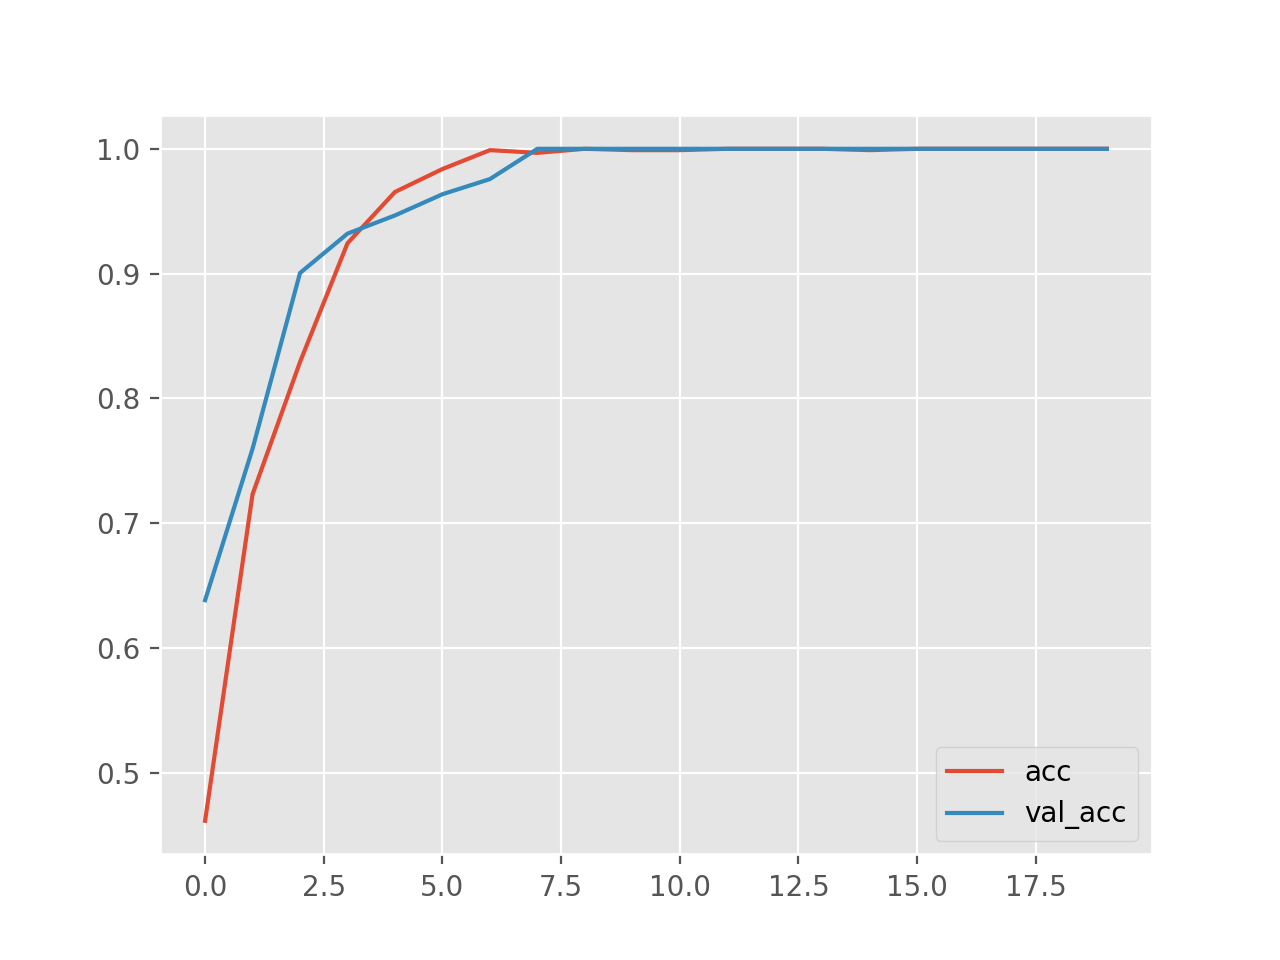

In [15]:
pd.DataFrame(history.history, columns=['acc','val_acc']).plot()

<IPython.core.display.Javascript object>


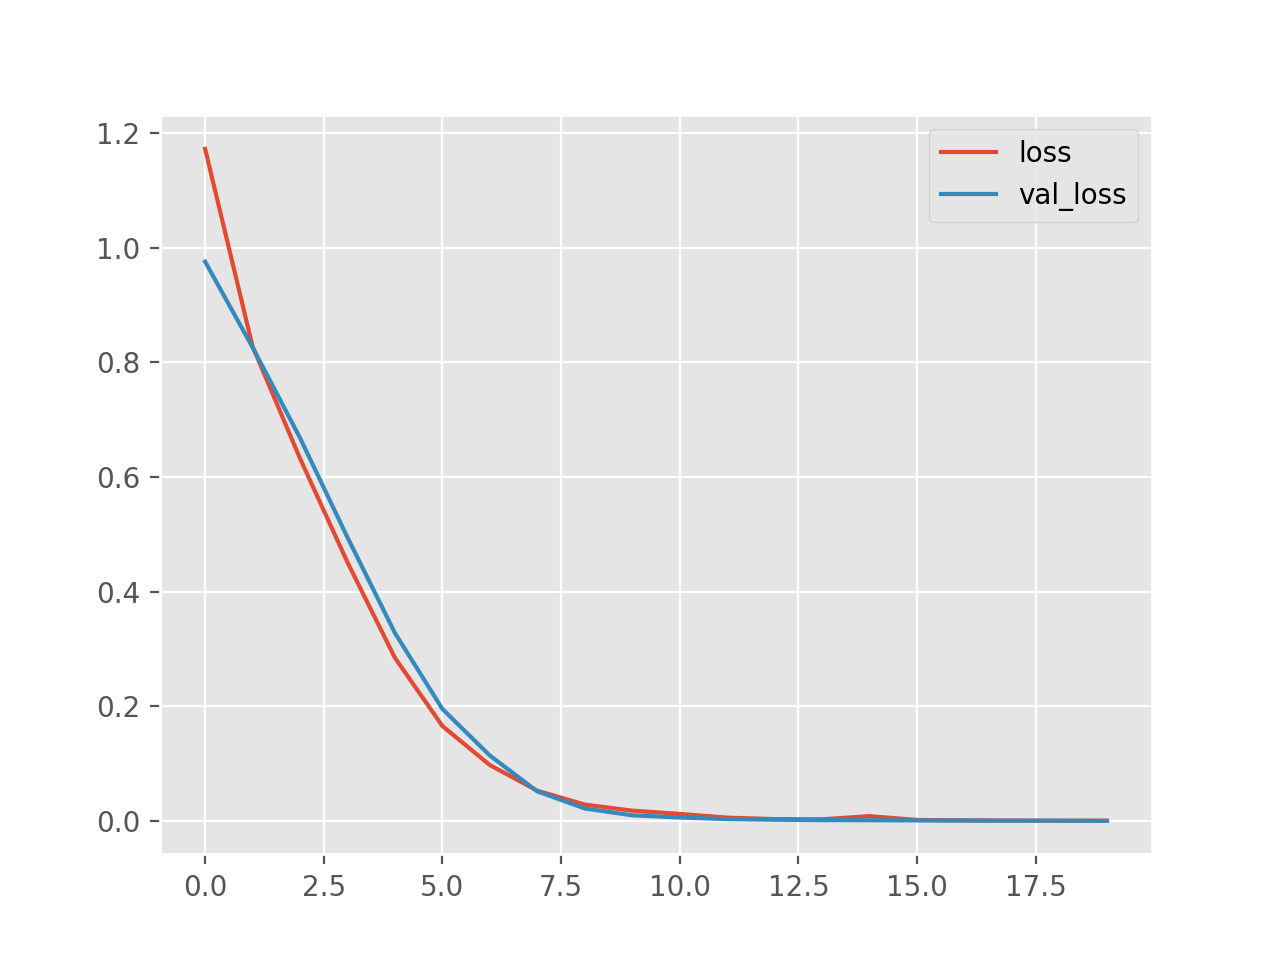

In [16]:
pd.DataFrame(history.history, columns=['loss','val_loss']).plot()

In [17]:
print(f"loss, acc {model.evaluate(test_x, test_y)}")

585/585 [==============================] - 0s 268us/step
loss, acc [8.638594870437653e-05, 1.0]


# Export training data

In [18]:
with open('../data/train.json', 'w') as fd:
    ujson.dump((train_x.tolist(),train_y.tolist()), fd,ensure_ascii=True)

with open('../data/validate.json', 'w') as fd:
    ujson.dump((validate_x.tolist(),validate_y.tolist()), fd,ensure_ascii=True)

with open('../data/test.json', 'w') as fd:
    ujson.dump((test_x.tolist(),test_y.tolist()), fd,ensure_ascii=True)

# Export feature params for the integration reactor script

In [19]:
with open('../reactor/model_config_params.json','w') as fd:
    ujson.dump(dict(std=stdsc.scale_.tolist(),mean=stdsc.mean_.tolist(), lookback=LOOKBACK),fd,ensure_ascii=True)

with open('../reactor/labels_encoding.json','w') as fd:
    ujson.dump(le.classes_,fd,ensure_ascii=True)

In [20]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 148, 32)           320       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 49, 32)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 47, 32)            3104      
_________________________________________________________________
gru_1 (GRU)                  (None, 20)                3180      
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 63        
Total params: 6,667
Trainable params: 6,667
Non-trainable params: 0
_________________________________________________________________
